In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("dark")
import os

from pipeline.preprocessing import preprocess
from pipeline.walkforward import WFCVGenerator
from config.config_types import AppConfig
from utils.inference_utils import format_legend_name
import torch


from utils.paths import CONFIG_DIR, SP500COPY_PATH, SP500_PATH, DATA_DIR, VOL_EXPERIMENTS_DIR, PRICE_EXPERIMENTS_DIR

DEVICE = "cuda"

In [16]:
#df_sp = pd.read_parquet(SP500_PATH)
#df_sp

- de-comment this to predict a single stock and see how it performs in predicting

In [17]:
#df = preprocess()

#permno = np.random.choice(df["permno"].unique())
#print(permno)
#permno = 10107 # MSFT
#df_permno = df[df["permno"]==permno]
#df_permno["var"].plot(kind="line")

In [18]:
#df_permno["t"] = range(len(df_permno))
#df_permno 

In [6]:
cfg_mlp = AppConfig.from_dict(f"{CONFIG_DIR}/vol_mlp.yaml")
cfg_cnn = AppConfig.from_dict(f"{CONFIG_DIR}/vol_cnn.yaml")
cfg_lstm = AppConfig.from_dict(f"{CONFIG_DIR}/vol_lstm.yaml")
cfg_transformer = AppConfig.from_dict(f"{CONFIG_DIR}/vol_transformer.yaml")

wf = WFCVGenerator(cfg_lstm.walkforward)


**Skip if not using OLS**

In [20]:
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Lasso
#
#
## should be generated from a "full" wf (all obs) to compare with other models
#data_ols = {}
#
#
#
#for i, fold_data in enumerate(wf.folds()):
#    size = fold_data[4]
#
#    data_ols[i] = fold_data
#    print(i)
#    #if i == fold_num:
#    #    break
#
#
#Xtr, ytr, Xv, yv, Xte, yte, Xtr_val, ytr_val, Xte_merged, yte_merged, id_tr, id_v, id_te, windows_tr, windows_te, windows_v = data_ols[0]
#print(Xtr_val.shape)


In [21]:

#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
#import numpy as np
#
## 1. Helper to flatten 3D/2D time-series data for OLS
#def prepare_sklearn_input(X):
#    X = np.asarray(X)
#    if X.ndim == 3: # (N, T, D) -> (N, T*D)
#        N, T, D = X.shape
#        return X.reshape(N, -1)
#    elif X.ndim == 2: # (N, T) -> (N, T)
#        return X
#    return X
#
## 2. Prepare the data
## Xtr_val is your training set, Xte is your test set
#X_train_ols = prepare_sklearn_input(Xtr_val)
#X_test_ols  = prepare_sklearn_input(Xte_merged)
#
## Ensure targets are the right shape (N,) or (N, 1)
#y_train_ols = np.asarray(ytr_val)
#y_test_truth = np.asarray(yte_merged)
#
## 3. Fit OLS
#ols_full = LinearRegression()
#ols_full.fit(X_train_ols, y_train_ols)
#
#lasso_full = Lasso(fit_intercept=True, alpha=0.05).fit(X_train_ols, y_train_ols)
#
#
## 4. Predict
#y_pred_te_ols = ols_full.predict(X_test_ols)
#y_pred_tr_ols = ols_full.predict(X_train_ols)
#y_pred_te_lasso = lasso_full.predict(X_test_ols)
#y_pred_tr_lasso = lasso_full.predict(X_train_ols)
#
## 5. Check Metrics
## Flatten both for safe comparison
#mse_ols = mean_squared_error(y_test_truth.ravel(), y_pred_te_ols.ravel()) 
#mse_lasso = mean_squared_error(y_test_truth.ravel(), y_pred_te_lasso.ravel()) 
#mse_tr_ols  = mean_squared_error(y_train_ols.ravel(), y_pred_tr_ols.ravel())
#print(f"OLS Test MSE: {mse_ols:.6f}")
#print(f"LASSO Test MSE: {mse_lasso:.6f}")
#print(f"OLS Train MSE: {mse_tr_ols:.6f}")
#print(np.var(ytr_val))

In [4]:
data = {}



for i, fold_data in enumerate(wf.folds()):
    size = fold_data[4]
    y_test = fold_data[5]

    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break

use = data[0]


Xtr             = use[0]
ytr             = use[1]
Xv              = use[2]
yv              = use[3]
Xte             = use[4]
yte             = use[5]
Xtr_val         = use[6]
ytr_val         = use[7]
Xte_merged      = use[8]
yte_merged      = use[9]
id_tr           = use[10]
id_v            = use[11]
id_te           = use[12]
window_train    = use[13]
window_val      = use[14]
window_test     = use[15]
X_scaler        = use[16]
y_scaler        = use[17]
X_scaler_merged = use[18]
y_scaler_merged = use[19]


0


In [10]:
# ---- FIXED experiment names (cannot change) ----
exp_names = {
    "cnn": {
        "muon": "exp_169_cnn_100_muon_icml_3",
        "adam": "exp_037_cnn_100_adam_lr",
        "sgd" : "exp_041_cnn_100_sgd",
    },
    "lstm": {
        "muon": "exp_036_lstm_100_muon_lr",
        "adam": "exp_039_lstm_100_adam_lr",
        "sgd" : "exp_042_lstm_100_sgd",
    },
    "mlp": {
        "muon": "exp_035_mlp_100_muon_lr",
        "adam": "exp_038_mlp_100_adam_lr",
        "sgd" : "exp_043_mlp_100_sgd",
    },
    "transformer": {
        "adam": "exp_179_transformer_100_adam_lr",
        "muon": "exp_180_transformer_100_muon",
        'sgd': 'exp_181_transformer_100_sgd'
    }
}


# ---- CFG mapping (your cfg objects) ----
cfgs = {
    "cnn":  cfg_cnn,
    "lstm": cfg_lstm,
    "mlp":  cfg_mlp,
    "transformer":  cfg_transformer,
}


# ---- Trial (fixed) ----
trial = "trial_search_best"


# ---- Build the 9 experiments ----
experiments = []
for model in ["cnn", "lstm", "mlp", "transformer"]:
    for opt in ["muon", "adam", "sgd"]:
        experiments.append({
            "name": exp_names[model][opt],
            "cfg":  cfgs[model],
            "trial": trial
        })



names = [exp['name'] for exp in experiments]
trials = [exp['trial'] for exp in experiments]
cfgs = [exp['cfg'] for exp in experiments]

fold_num = 0
base_paths = [f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/" for name, trial in zip(names, trials)]
ckpt_paths = [f"{base}fold_{fold_num:03d}/model_best.pt" for base in base_paths]
checkpoints = [torch.load(cp, map_location=DEVICE) for cp in ckpt_paths]

base_paths

['/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_169_cnn_100_muon_icml_3/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_037_cnn_100_adam_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_041_cnn_100_sgd/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_036_lstm_100_muon_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_039_lstm_100_adam_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_042_lstm_100_sgd/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_035_mlp_100_muon_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_038_mlp_100_adam_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_043_mlp_100_sgd/

In [6]:
import os
import json
import torch

exp_names = [
    "exp_187_lstm_100_sgd_lstm_100_adam_lr",
    "exp_187_lstm_100_sgd_lstm_100_adam_lr",
    "exp_185_lstm_100_adam_lr_lstm_100_sgd",
    "exp_039_lstm_100_adam_lr",
    "exp_042_lstm_100_sgd",
]
trial_names = [
    "trial_20260107_130945",
    "trial_20260125_160922",
    "trial_20260107_122917",
    "trial_search_best",
    "trial_search_best",
]
fold_num = 0

experiments = []
cool_names = []
cool_indices = []

counter = 0
for name, trial in zip(exp_names, trial_names):  # <-- key fix
    counter += 1
    base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
    config_path = os.path.join(base, "config_snapshot.json")

    if not os.path.exists(config_path):
        # helpful debug
        parent = os.path.join(VOL_EXPERIMENTS_DIR, name)
        existing = sorted(os.listdir(parent)) if os.path.isdir(parent) else []
        raise FileNotFoundError(
            f"Missing {config_path}\n"
            f"Existing trials under {parent}: {existing[:20]}"
        )

    with open(config_path, "r") as f:
        cfg = json.load(f)["cfg"]

    cfg = AppConfig.from_dict(cfg)
    lr = float(cfg.trainer.hparams.get("lr"))
    optim = cfg.trainer.hparams.get("optimizer_type")

    cool_name = f"lstm_{optim}"  # <-- fix naming
    if cool_name not in cool_names:
        cool_names.append(cool_name)
        cool_indices.append(counter)

    experiments.append({
        "name": name,
        "trial": trial,
        "cfg": cfg,          # use the actual cfg you loaded
        "lr": lr,
        "optim": optim,
    })

# ---- Paths ----
base_paths = [f"{VOL_EXPERIMENTS_DIR}/{e['name']}/{e['trial']}/" for e in experiments]
ckpt_paths = [f"{b}fold_{fold_num:03d}/model_best.pt" for b in base_paths]

# ---- Load ----
checkpoints = [torch.load(cp, map_location=DEVICE) for cp in ckpt_paths]

experiments

[{'name': 'exp_187_lstm_100_sgd_lstm_100_adam_lr',
  'trial': 'trial_20260107_130945',
  'cfg': AppConfig(model=ModelConfig(name='lstm', hparams={'mlp_hidden_sizes': [512, 256], 'mlp_activation': ['relu', 'relu'], 'dropout_rate': 0, 'lstm_hidden_sizes': [256, 256], 'lstm_dropout': 0, 'bidirectional': False, 'readout': 'last', 'use_ln': False, 'conv_channels': [64, 128, 256], 'conv_activation': ['relu', 'relu', 'relu'], 'kernel_size': 3, 'padding': 1, 'pool': 'adaptive_max', 'pool_k': 4, 'use_bn': False, 'output_activation': 'linear', 'n_layers': 2}, search={}), trainer=TrainerConfig(hparams={'epochs': 50, 'batch_size': 512, 'torch_patience': 10, 'min_delta': '1e-10', 'optuna_patience': 10, 'loss': 'mse', 'metrics': ['mae', 'mse', 'dir_acc', 'qlike'], 'val_every': 1, 'optimizer_type': 'sgd', 'weight_decay': 0.019785566992218694, 'lr': 0.09846267508453047, 'initialization': 'exp_039_lstm_100_adam_lr/trial_search_best/fold_000'}, search={'weight_decay': FloatSpec(low=1e-05, high=1, log=Fa

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import numpy as np
from models import create_model

def _prepare_X_for_ols(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    if X.ndim == 2:
        return X
    if X.ndim == 3:
        N, T, D = X.shape
        return X.reshape(N, T * D)
    raise ValueError(f"Unexpected X shape for OLS: {X.shape}")

# Replace the existing _infer_input_shape with this version
def _infer_input_shape(cfg, X_sample, state_dict):
    """
    Infer model input_shape from a sample.
    Accepts:
      (T,)          -> univariate row
      (T,D)         -> multivariate row
      (N,T)         -> whole univariate batch
      (N,T,D)       -> whole multivariate batch
    Returns shapes expected by create_model for each architecture.
    """
    name = cfg.model.name.lower()
    shape = X_sample.shape
    # Remove leading batch dimension if accidentally passed
    if X_sample.ndim == 2 and name == "lstm" and shape[0] != cfg.walkforward.lags and shape[1] == cfg.walkforward.lags:
        # Probably (N,T); leave as handled below
        pass

    if name in ["lstm", 'transformer']:
        # LSTM expects (T,D)
        if X_sample.ndim == 1:              # (T,)
            return (shape[0], 1)
        elif X_sample.ndim == 2:
            if shape[0] == cfg.walkforward.lags and shape[1] != 1:
                # row already (T,D)
                return (shape[0], shape[1])
            elif shape[1] == cfg.walkforward.lags:
                # batch (N,T) -> treat as univariate features
                return (shape[1], 1)
            else:
                # row (T,1) or (T,D)
                return (shape[0], shape[1])
        elif X_sample.ndim == 3:            # (N,T,D)
            return (shape[1], shape[2])
        else:
            raise ValueError(f"Unexpected LSTM sample shape: {shape}")

    elif name == "simplecnn":
        # CNN expects (C,L) with C=1
        if X_sample.ndim == 1:              # (T,)
            return (1, shape[0])
        elif X_sample.ndim == 2:
            if shape[1] == cfg.walkforward.lags and shape[0] != 1:
                # (N,T) batch -> length = T
                return (1, shape[1])
            elif shape[0] == 1:             # (1,T)
                return (1, shape[1])
            else:                           # (T,D) flattened later
                return (1, shape[0]*shape[1])
        elif X_sample.ndim == 3:            # (N,T,D)
            return (1, shape[1])            # treat D collapsed upstream
        else:
            raise ValueError(f"Unexpected CNN sample shape: {shape}")

    elif name == "mlp":
        # MLP expects flattened window (T,) (or T*D)
        if X_sample.ndim == 1:              # (T,)
            return (shape[0],)
        elif X_sample.ndim == 2:
            if shape[1] == cfg.walkforward.lags and shape[0] != cfg.walkforward.lags:
                # (N,T) batch
                return (shape[1],)
            else:                           # (T,D)
                return (shape[0]*shape[1],)
        elif X_sample.ndim == 3:            # (N,T,D)
            return (shape[1]*shape[2],)
        else:
            raise ValueError(f"Unexpected MLP sample shape: {shape}")

    else:
        raise ValueError(f"Unknown model {cfg.model.name}")

@torch.inference_mode()
def _prepare_batch(cfg, x_row):
    name = cfg.model.name.lower()
    # x_row is a single sample slice from X_test
    if name == "mlp":
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0)
        elif x_row.ndim == 2:
            xb = torch.as_tensor(x_row.reshape(-1), dtype=torch.float32).unsqueeze(0)
        else:
            raise ValueError
    elif name == "simplecnn":
        # expect (N, C, L); x_row maybe (T,) or (T,D)
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        elif x_row.ndim == 2:
            # collapse feature dim
            x_flat = x_row.reshape(-1)
            xb = torch.as_tensor(x_flat, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        else:
            raise ValueError
    elif name in ["lstm", 'transformer']:
        # expect (N, T, D)
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        elif x_row.ndim == 2:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0)
        else:
            raise ValueError
    else:
        raise ValueError
    return xb

def build_model_from_checkpoint(cfg, checkpoint, X_example):
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint["model_state"].items()}
    input_shape = _infer_input_shape(cfg, X_example, state_dict)
    output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(DEVICE).eval()
    return model

@torch.inference_mode()
def infer_sequential(model, cfg, X_test, y_test, limit=None, autoregressive=False, device="cuda"):
    """
    Sequential single-row inference over chronologically sorted X_test.
    For autoregressive=True, we start from X_test[0] and then roll forward
    using our own predictions.
    Returns (y_true, preds) with shape (N, output_dim).
    """
    preds = []
    limit = len(X_test) if limit is None else limit

    if autoregressive:
        # Keep a *list* of windows; each window has same shape as X_test[0]
        X_ar = [np.array(X_test[0], copy=True)]
    else:
        X_ar = None

    for i in range(limit):
        if autoregressive:
            # Always feed the *last* window in the autoregressive buffer
            x_in = X_ar[-1]
        else:
            x_in = X_test[i]

        # Debug: check shapes
        # print("x_in shape:", np.asarray(x_in).shape)

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)

        if autoregressive:
            # assume scalar output; if multi-dim adjust accordingly
            next_val = pb[0]

            # x_in is a window of length L; we drop the first element and append the prediction
            x_in = np.asarray(x_in)
            next_window = np.concatenate([x_in[1:], [next_val]])

            # store new window in buffer
            X_ar.append(next_window)

    preds = np.vstack(preds)  # (N, output_dim)
    y_true = np.asarray(y_test[:limit])
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    return y_true, preds

def plot_forecast_overlay(x_input, y_true, y_pred, title="Forecast overlay", horizon_dim: int = 0):
    """
    Plot with an initial burn-in window (the model input) followed by sequential forecasts.
    Assumes:
      x_input: shape (T,) or (T,D)  -> last observed history used for first prediction
      y_true : shape (N, H) or (N,1)
      y_pred : shape (N, H) or (N,1)
    horizon_dim selects which target dimension to display (default 0).
    """
    # Extract burn-in (history) series
    x_input = np.asarray(x_input)
    if x_input.ndim == 2:
        history = x_input[:, horizon_dim] if x_input.shape[1] > horizon_dim else x_input[:, 0]
    else:
        history = x_input.ravel()

    # Extract forecast true/pred series for chosen horizon dimension
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.ndim == 2:
        true_future = y_true[:, horizon_dim] if y_true.shape[1] > horizon_dim else y_true[:, 0]
    else:
        true_future = y_true.ravel()
    if y_pred.ndim == 2:
        pred_future = y_pred[:, horizon_dim] if y_pred.shape[1] > horizon_dim else y_pred[:, 0]
    else:
        pred_future = y_pred.ravel()

    T = len(history)
    F = len(true_future)

    # Build unified time index: negative = burn-in, non-negative = forecast
    idx_history = np.arange(-T, 0)
    idx_future  = np.arange(0, F)

    plt.figure(figsize=(12,4))
    plt.plot(idx_history, history, label="History", color="#555555", lw=2)
    plt.plot(idx_future, true_future, label="True Future", color="#1f77b4", lw=2)
    plt.plot(idx_future, pred_future, label="Predicted Future", color="#d62728", lw=2)

    # Vertical separator at forecast start
    plt.axvline(x=-0.5, color="k", linestyle="--", linewidth=1)
    plt.axhline(y=pred_future[0], color="r", linestyle="--", linewidth=1)

    # Metrics
    if len(true_future) == len(pred_future):
        mse = mean_squared_error(true_future, pred_future)
        plt.text(0.9, 0.97, f"MSE={mse:.4g}",
                 transform=plt.gca().transAxes, va="top", ha="left", fontsize=10,
                 bbox=dict(boxstyle="round", fc="white", alpha=0.6, ec="#cccccc"))

    plt.title(f"{title}")
    plt.xlabel("Time (negative = burn-in history, >=0 = forecast steps)")
    plt.ylabel("Value")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    
# ---- Usage example ----
# Assuming data[fold_num] loaded earlier:
use = data[fold_num]
Xtr             = use[0]
ytr             = use[1]
Xv              = use[2]
yv              = use[3]
Xte             = use[4]
yte             = use[5]
Xtr_val         = use[6]
ytr_val         = use[7]
Xte_merged      = use[8]
yte_merged      = use[9]
id_tr           = use[10]
id_v            = use[11]
id_te           = use[12]
window_train    = use[13]
window_val      = use[14]
window_test     = use[15]
X_scaler        = use[16]
y_scaler        = use[17]
X_scaler_merged = use[18]
y_scaler_merged = use[19]
X_test_use = Xte  # or Xte_merged if merge mode
y_test_use = yte
print(X_test_use.shape)


def run_all_experiments_sequential(
    experiments,
    checkpoints,
    X_test,
    y_test,
    limit=None,
    autoregressive=False,
    device=DEVICE,
):
    """
    For each experiment:
      - build model from checkpoint
      - run infer_sequential
    Returns:
      results: dict[clean_name] = {"y_true": ..., "y_pred": ..., "cfg": cfg}
    """
    results = {}

    for exp, ckpt in zip(experiments, checkpoints):
        cfg = exp["cfg"]
        raw_name = exp["name"]
        legend_name = format_legend_name(raw_name)

        # Build model using one sample as shape example
        model = build_model_from_checkpoint(cfg, ckpt, X_test[0])

        # Run sequential inference
        y_true, y_pred = infer_sequential(
            model,
            cfg,
            X_test,
            y_test,
            limit=limit,
            autoregressive=autoregressive,
            device=device,
        )

        results[legend_name] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "cfg": cfg,
        }

    return results




(564795, 100)


In [43]:

# --- 1. To get just a list of names ---
clean_names = [format_legend_name(n) for n in names]
clean_names = [f"{n} {i}" if n in clean_names[:i] else n for i, n in enumerate(clean_names)]



# Print
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_ar_cnn, title=f"{name_cnn} - fold {fold_num} - PERMNO:{permno}")
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_ar_lstm, title=f"{name_lstm} - fold {fold_num} - PERMNO:{permno}")
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_first, title=f"{clean_names[0]} - fold {fold_num} - PERMNO {permno}")
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_second, title=f"{clean_names[1]} - fold {fold_num} - PERMNO {permno}")
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_third, title=f"{clean_names[2]} - fold {fold_num} - PERMNO {permno}")
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_ols[:200], title=f"OLS 100 - fold {fold_num} - PERMNO:{permno}")
X_test_use = Xte   # or Xte_merged
y_test_use = yte

results_seq = run_all_experiments_sequential(
    experiments=experiments,
    checkpoints=checkpoints,
    X_test=X_test_use,
    y_test=y_test_use,
    limit=200,              # or None for full length
    autoregressive=False,   # or True if you want AR mode
    device=DEVICE,
)

for model_name, result in results_seq.items():
    y_true_seq = result["y_true"]
    y_pred_seq = result["y_pred"]

    #plot_forecast_overlay(
    #    x_input=X_test_use[0],
    #    y_true=y_true_seq,
    #    y_pred=y_pred_seq,
    #    title=f"Forecast overlay - {model_name}",
    #)



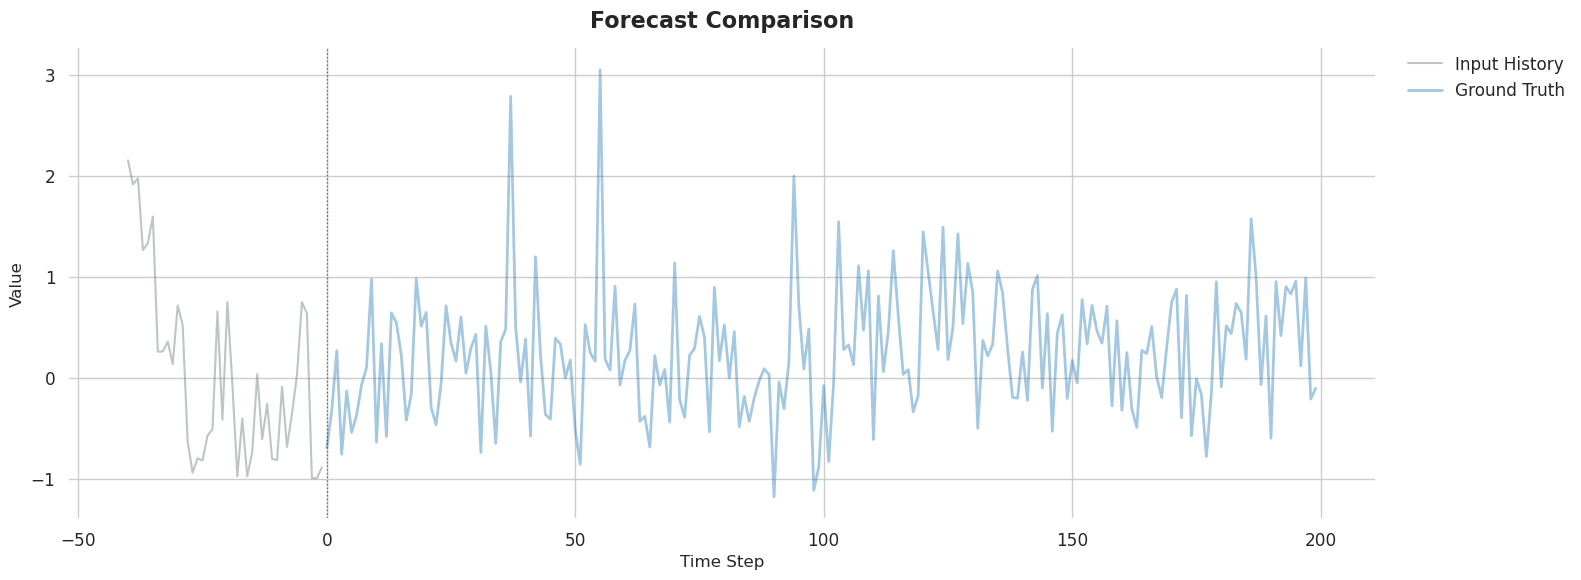

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_beautiful_forecasts(x_history, y_true, predictions_dict, title="Model Comparison", zoom_history=30):
    """
    A cleaner, aesthetically pleasing plot for time-series forecasts.
    
    Args:
        zoom_history: Int. How many steps of history to show (e.g., 30). 
                      Set to None to show all history.
    """
    # 1. Setup Style
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.1)
    
    # Create figure
    plt.figure(figsize=(16, 6), dpi=100)
    
    # 2. Prepare Data
    history = np.asarray(x_history).ravel()
    true_future = np.asarray(y_true).ravel()
    
    # Optional: Slice history to only show the relevant end portion
    if zoom_history is not None and len(history) > zoom_history:
        history = history[-zoom_history:]
        # Adjust indices so the last history point is at -1
        idx_history = np.arange(-len(history), 0)
    else:
        idx_history = np.arange(-len(history), 0)
        
    idx_future = np.arange(0, len(true_future))
    
    # 3. Plot Context (History & Ground Truth)
    # We make these slightly transparent (alpha) so predictions stand out
    plt.plot(idx_history, history, label="Input History", color="#7f8c8d", alpha=0.5, linewidth=1.5, linestyle="-")
    plt.plot(idx_future, true_future, label="Ground Truth", color="#1f77b4", alpha=0.4, linewidth=2)

    # 4. Plot Models
    # distinct, high-contrast colors
    colors = ["#e74c3c", "#3498db", "#2ecc71", "#9b59b6", "#f1c40f"] 
    markers = ['o', 's', '^', 'D', 'v', 'p', 'X', '*']
    
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        pred_flat = np.asarray(y_pred).ravel()
        
        # Safe MSE calculation
        min_len = min(len(true_future), len(pred_flat))
        mse = mean_squared_error(true_future[:min_len], pred_flat[:min_len])
        
        # Pick color cyclically
        c = colors[i % len(colors)]
        
        plt.plot(idx_future[:min_len], pred_flat[:min_len], 
                 label=f"{model_name}\n(MSE: {mse:.4f})", 
                 color=c, 
                 marker=markers[i % len(markers)], 
                 markersize=3,
                 linewidth=1.5,  # Slightly thicker than truth
                 alpha=1)

    # 5. Aesthetics
    plt.axvline(x=0, color="black", linestyle=":", linewidth=1, alpha=0.5)
    
    plt.title(title, fontsize=16, pad=15, fontweight='bold')
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    
    # Clean up borders (despine)
    sns.despine(left=True, bottom=True)
    
    # Legend placement - move outside if it's too crowded
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
    
    plt.tight_layout()
    plt.show()

# ================= Usage =================
model_predictions = {
#    clean_names[0]: y_pred_seq_first,
#    clean_names[1]: y_pred_seq_second
#    clean_names[2]: y_pred_seq_third
#    "OLS": y_pred_ols[:200]
}

plot_beautiful_forecasts(
    x_history=X_test_use[0], 
    y_true=y_true_seq, 
    predictions_dict=model_predictions, 
    title=f"Forecast Comparison",
    zoom_history=40  # Only showing last 40 steps of history
)

**This computes eigenvalues**

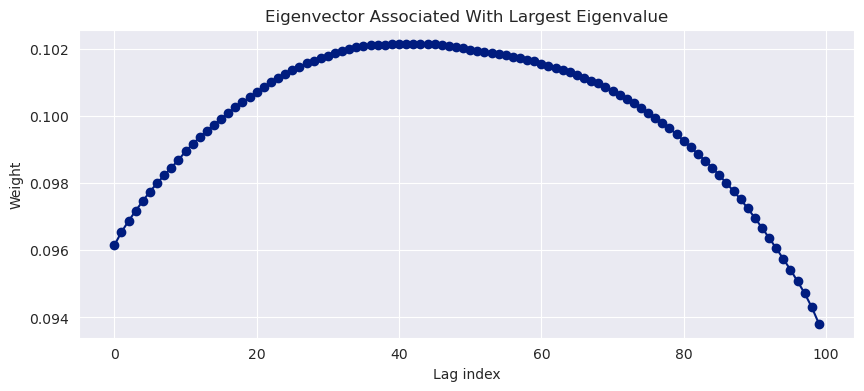

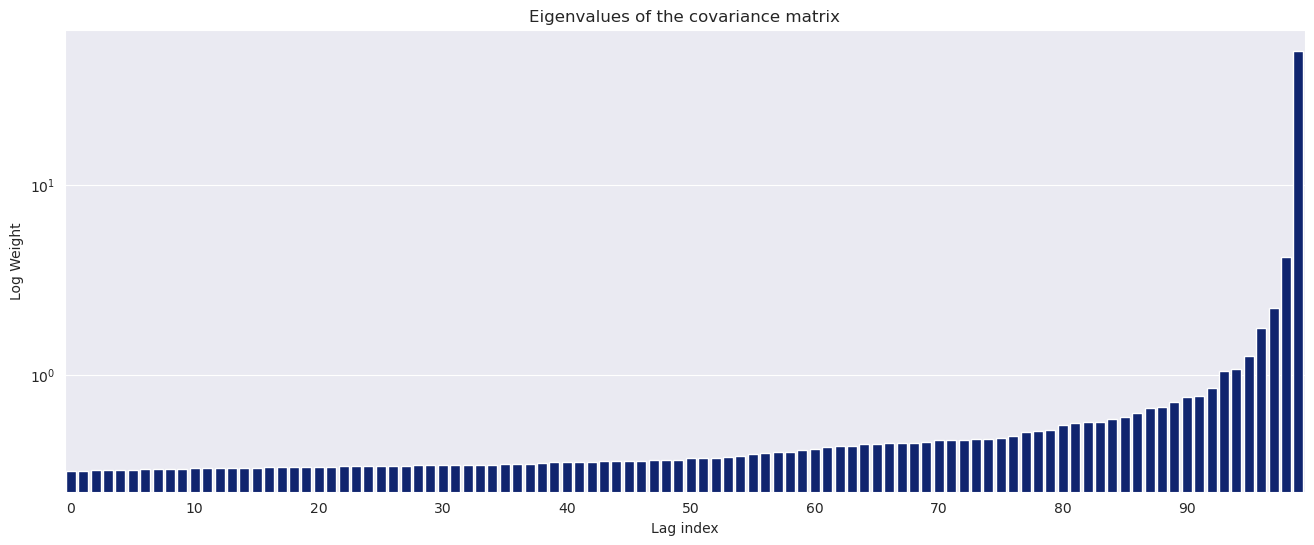

In [9]:
import numpy as np

# X: (1_500_000, 100)
Sigma = (Xtr_val.T @ Xtr_val) / Xtr_val.shape[0]    # shape (100, 100)

# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(Sigma)

v1 = eigvecs[:, -1]
plt.figure(figsize=(10,4))
plt.plot(v1, marker="o")
plt.title("Eigenvector Associated With Largest Eigenvalue")
plt.xlabel("Lag index")
plt.ylabel("Weight")
plt.grid(True)
plt.show()

plt.figure(figsize=(16,6))
sns.barplot(eigvals)
plt.title("Eigenvalues of the covariance matrix")
plt.xlabel("Lag index")
plt.ylabel("Log Weight")
plt.yscale("log")
plt.xticks(ticks=np.arange(0, len(eigvals), 10))  # Show one x-axis marker every 10
plt.show()

In [10]:
import numpy as np
from sklearn.decomposition import PCA

# Xtr_val: shape (n_samples, n_features)
# Make sure it's a NumPy array
X = np.asarray(Xtr_val)

# Fit PCA
pca = PCA(n_components=5)
pca.fit(X)

# Explained variance and ratios
explained_var = pca.explained_variance_               # λ1, λ2, λ3
explained_ratio = pca.explained_variance_ratio_       # % of total variance

print("Eigenvalues (explained variances):")
print(explained_var)

print("\nExplained variance ratios:")
for i, r in enumerate(explained_ratio, 1):
    print(f"PC{i}: {r*100:.2f}%")


Eigenvalues (explained variances):
[50.56873582  4.15560206  2.23535127  1.75812515  1.24788066]

Explained variance ratios:
PC1: 50.57%
PC2: 4.16%
PC3: 2.24%
PC4: 1.76%
PC5: 1.25%


In [58]:
#plt.figure(figsize=(12,8))
#sns.heatmap(pd.DataFrame(Xtr_val).corr())

In [59]:
#plt.figure(figsize=(16, 8))
#plt.title("OLS and LASSO Coefficients")
#plt.bar(range(len(ols_full.coef_)), ols_full.coef_, color='blue', alpha=0.7, label="OLS")
#plt.bar(range(len(lasso_full.coef_)), lasso_full.coef_, color='orange', alpha=0.7, label="LASSO")
#plt.legend()
#plt.xlabel("Feature Index")
#plt.ylabel("Coefficient Value")
#plt.grid(True)
#plt.tight_layout()
#plt.show()
#
#

<Figure size 1000x600 with 0 Axes>

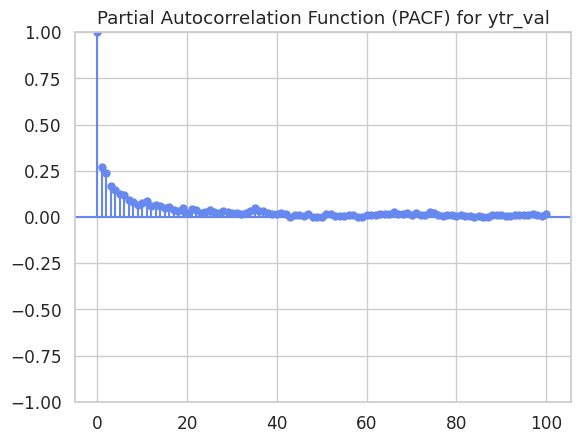


Significant Lags:
    Lag      PACF
0     0  1.000000
1     1  0.272554
2     2  0.235421
3     3  0.168667
4     4  0.147266
5     5  0.122123
6     6  0.118152
7     7  0.089957
8     8  0.080053
9     9  0.064580
10   10  0.076430
11   11  0.087195
12   12  0.059182
13   13  0.066801
14   14  0.061387
16   16  0.052003


In [60]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import pandas as pd
import matplotlib.pyplot as plt

# Plot PACF for ytr_val
plt.figure(figsize=(10, 6))
plot_pacf(y_test_use, lags=100, method='ywm', alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF) for ytr_val")
plt.show()

# Calculate the raw PACF values
# method='ywm' is consistent with the default in plot_pacf (Yule-Walker without bias adjustment)
pacf_values = pacf(y_test_use, nlags=100, method='ywm')

# Create a DataFrame for cleaner inspection
df_pacf = pd.DataFrame({
    'Lag': range(len(pacf_values)), 
    'PACF': pacf_values
})


# If you need specific significant lags (e.g., > 0.05)
significant_lags = df_pacf[abs(df_pacf['PACF']) > 0.05]
print("\nSignificant Lags:")
print(significant_lags)

In [11]:
@torch.inference_mode()
def probe_num(model, cfg, size, num=1, pacf_values=None, limit=None, autoregressive=False, device="cuda"):
    """
    Probes the model's response to a 'shock' input.

    If pacf_values is None:
        x_in is a one-hot-like vector with `num` at position i and 0 elsewhere.
    If pacf_values is not None:
        we build a more realistic shock by spreading `num` across future positions
        according to pacf_values (e.g., geometric decay from PACF).

        Concretely, for each i:
            x_in[i + k] += num * pacf_values[k],  for k where i + k < size.

    Returns a vector of predictions of length `limit` (or `size` if limit is None).
    """
    preds = []
    limit = size if limit is None else min(limit, size)

    # ensure pacf_values is a numpy array if provided
    if pacf_values is not None:
        pacf_values = np.asarray(pacf_values)

    # (unused in your probing, but keep it safe)
    X_ar = [] if autoregressive else None

    for i in range(limit):
        # start from all zeros
        x_in = np.zeros(size, dtype=float)

        if pacf_values is None:
            # original "pure" probe: a single non-zero feature
            x_in[i] = num
        else:
            # more realistic AR-like probe:
            # spread the shock from position i forward according to pacf_values
            max_len = min(len(pacf_values), size - i)
            x_in[i:i+max_len] = num * pacf_values[:max_len]

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)

        if autoregressive:
            # assume scalar output; if multi-dim adjust accordingly
            next_val = pb[0]

            # x_in is a window of length size; drop first element, append prediction
            next_window = np.concatenate([x_in[1:], [next_val]])
            X_ar.append(next_window)

    preds = np.vstack(preds)  # (N, output_dim)
    return preds.reshape(-1)

@torch.inference_mode()
def probe_interaction(model, cfg, size, pos=[-1,-2], nums=[1,1], device="cuda"):
    """
    Probes the model's response to a 'shock' input.

    If pacf_values is None:
        x_in is a one-hot-like vector with `num` at position i and 0 elsewhere.
    If pacf_values is not None:
        we build a more realistic shock by spreading `num` across future positions
        according to pacf_values (e.g., geometric decay from PACF).

        Concretely, for each i:
            x_in[i + k] += num * pacf_values[k],  for k where i + k < size.

    Returns a vector of predictions of length `limit` (or `size` if limit is None).
    """
    preds = []

    # start from all zeros
    x_in = np.zeros(size, dtype=float)

    # original "pure" probe: a single non-zero feature
    x_in[pos[0]] = nums[0]
    x_in[pos[1]] = nums[1]

    xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
    pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
    preds.append(pb)


    preds = np.vstack(preds)  # (N, output_dim)
    return preds.reshape(-1)



@torch.inference_mode()
def test_random_uniform(model, cfg, size, low=-1.0, high=1.0, n_samples=100, seed=None, device="cuda"):
    """
    Feed the model random uniform noise vectors of dimension `size`.
    Returns predictions of shape (n_samples,).
    """
    if seed is not None:
        np.random.seed(seed)

    preds = []

    for _ in range(n_samples):
        x_in = np.random.uniform(low, high, size=size).astype(float)
        xb = _prepare_batch(cfg, x_in).to(device)
        pb = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(pb)

    preds = np.vstack(preds)  # (n_samples, output_dim)
    return preds.squeeze()



@torch.inference_mode()
def test_gaussian_noise(model, cfg, size, mean=0.0, std=1.0, n_samples=100, seed=None, device="cuda"):
    """
    Feed the model random Gaussian noise vectors N(mean, std^2)
    of dimension `size`.
    Returns predictions of shape (n_samples,).
    """
    if seed is not None:
        np.random.seed(seed)

    preds = []

    for _ in range(n_samples):
        x_in = np.random.normal(loc=mean, scale=std, size=size).astype(float)
        xb = _prepare_batch(cfg, x_in).to(device)
        pb = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(pb)

    preds = np.vstack(preds)
    return preds.squeeze()




In [12]:
from models import create_model
import json
from pathlib import Path

# Normalize MSE by target variance on each split
USE_NMSE = True
MERGE_TRAIN_VAL = False



# =========================
# Utilities
# =========================
def load_cfg(base) -> AppConfig:
    cfg_json = json.loads((base / "config_snapshot.json").read_text())
    return AppConfig.from_dict(cfg_json["cfg"])

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name in ["lstm", 'transformer']:
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def load_and_predict_nn(base_path, fold_idx, X_test, device="cuda"):
    """Load NN model for given fold and make predictions on test set."""
    try:
        base_path = Path(base_path)
        cfg = load_cfg(base_path)
        # Load checkpoint
        ckpt_path = base_path / f"fold_{fold_idx:03d}" / "model_best.pt"
        if not ckpt_path.exists():
            return None
        
        checkpoint = torch.load(ckpt_path, map_location=device)
        state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint["model_state"].items()}
        
        # Infer shapes
        input_shape = _make_input_shape_for_eval(cfg, X_test, state_dict)
        output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1
        
        # Create and load model
        model = create_model(cfg.model, input_shape, output_shape)
        model.load_state_dict(state_dict, strict=True)
        model.to(device).eval()
        
        # Make predictions
        yhat = _predict_batched(model, X_test, device=device, bs=8192)
        
        # Cleanup
        del model, checkpoint
        torch.cuda.empty_cache()
        
        return yhat
        
    except Exception as e:
        print(f"Error loading/predicting fold {fold_idx}: {e}")
        return None


In [42]:

cfgs = [cfg_transformer] * len(names)

{'adam': 'exp_179_transformer_100_adam_lr',
 'muon': 'exp_180_transformer_100_muon',
 'sgd': 'exp_181_transformer_100_sgd'}

In [58]:
from sklearn.metrics import mean_squared_error
import os 
import json 



fold_num = 0
checkpoints = []
base_paths = []
search_list = []
mses = []
import json
import torch

#exp_names = ["exp_201_eos_mlp", "exp_202_eos_mlp_v2"]

fold_num = 0

checkpoints = []
base_paths = []
search_list = []  # learning rates (or whatever you're collecting)
meta = []         # (optional) keep (name, trial)


for name, trial in zip(names, trial_names):  # <-- key fix
    base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
    ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
    config_path = f"{base}config_snapshot.json"

    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    checkpoints.append(checkpoint)
    base_paths.append(base)
    meta.append((name, trial))

    print(ckpt_path)

    with open(config_path, "r") as f:
        cfg_json = json.load(f)

    cfg = AppConfig.from_dict(cfg_json["cfg"])
    opt = cfg.trainer.hparams.get("optimizer_type")
    wd  = cfg.trainer.hparams.get("weight_decay")
    lr  = cfg.trainer.hparams.get("lr")

    print(f"name: {name} | trial: {trial}")
    print(f"optimizer: {opt}")
    print(f"weight_decay: {wd}")
    print(f"learning rate: {lr}\n")

    search_list.append(lr)


def mse(y_true, y_pred, limit=None):
    # Use first output dim (adjust if you care about others)
    return mean_squared_error(y_true, y_pred)

models = []
for i, exp in enumerate(experiments):
    name = exp["name"]

    cfg_obj  = cfgs[0]             # code-level cfg (cnn/lstm/mlp)
    ckpt     = checkpoints[i]
    path     = base_paths[i]

    # Build model using your helper
    model = build_model_from_checkpoint(cfg_obj, ckpt, X[0])
    ytr_hat = load_and_predict_nn(path, 0, Xtr)
    yval_hat = load_and_predict_nn(path, 0, Xv)
    yte_hat = load_and_predict_nn(path, 0, Xte)

    # Use infer_sequential to predict y's and compute mse
    #y_true_seq_train, y_pred_seq_train = infer_sequential(model, cfg_lstm, Xtr, ytr)
    #y_true_seq_val, y_pred_seq_val = infer_sequential(model, cfg_lstm, Xv, yv)
    #y_true_seq_test, y_pred_seq_test = infer_sequential(model, cfg_lstm, Xte, yte)

    #mse_train_seq = mse(y_true_seq_train, y_pred_seq_train)
    #mse_val_seq = mse(y_true_seq_val, y_pred_seq_val)
    #mse_test_seq = mse(y_true_seq_test, y_pred_seq_test)

    models.append(model)
    mse_train = mse(ytr_hat, ytr)
    mse_val   = mse(yval_hat,  yv)
    mse_test  = mse(yte_hat, yte)
    mses.append(mse_test)


    print(f"Model {i}: train={mse_train:.6f}  val={mse_val:.6f}  test={mse_test:.6f}")
    #print(f"Sequential MSE: train={mse_train_seq:.6f}  val={mse_val_seq:.6f}  test={mse_test_seq:.6f}")



/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_180_transformer_100_muon/trial_search_best/fold_000/model_best.pt
name: exp_180_transformer_100_muon | trial: trial_search_best
optimizer: muon
weight_decay: 0.08661761457749352
learning rate: 1.7073967431528103e-05

/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_179_transformer_100_adam_lr/trial_search_best/fold_000/model_best.pt
name: exp_179_transformer_100_adam_lr | trial: trial_search_best
optimizer: adam
weight_decay: 0.0
learning rate: 1.0719864040714885e-05

/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_181_transformer_100_sgd/trial_search_best/fold_000/model_best.pt
name: exp_181_transformer_100_sgd | trial: trial_search_best
optimizer: sgd
weight_decay: 0.013949386065204183
learning rate: 0.0028016351587162596

Model 0: train=0.430556  val=0.419313  test=0.379910
Model 1: train=0.429791  val=0.417136  test=0.378882
Model 2: train=0.531962  val=0.516211  test

In [64]:
from sklearn.metrics import mean_squared_error
import os 
import json 

name = names[0]
if False:
    fold_num = 0
    checkpoints = []
    base_paths = []
    search_list = []
    val_mses = []
    for trial in os.listdir(f"{VOL_EXPERIMENTS_DIR}/{name}"):
        try:
            base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
            ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
            checkpoint = torch.load(ckpt_path, map_location=DEVICE)
            checkpoints.append(checkpoint)
            base_paths.append(base)
            conifg_path = f"{base}config_snapshot.json"

            print(ckpt_path)
            with open(conifg_path, 'r') as f:
                cfg = json.load(f)

            cfg = cfg["cfg"]

            cfg = AppConfig.from_dict(cfg)
            search = {
                "bs": float(f"{cfg.trainer.hparams.get('batch_size'):.4f}"),
                "mom": float(f"{cfg.trainer.hparams.get('momentum'):.4f}"),
                "lr": float(f"{cfg.trainer.hparams.get('lr'):.4f}"),
                "wd": float(f"{cfg.trainer.hparams.get('weight_decay'):.4f}")
            }
            search_list.append(search)
            print(f"Search: {search}")
            print()

        except FileNotFoundError:
            continue

    def mse(y_true, y_pred, limit=None):
        # Use first output dim (adjust if you care about others)
        return mean_squared_error(y_true, y_pred)

    models = []
    for i, (ckpt, path) in enumerate(zip(checkpoints, base_paths)):
        model = build_model_from_checkpoint(cfgs[i], ckpt, Xte[0])
        ytr_hat = load_and_predict_nn(path, 0, Xtr)
        yval_hat = load_and_predict_nn(path, 0, Xv)
        yte_hat = load_and_predict_nn(path, 0, Xte)

        # Use infer_sequential to predict y's and compute mse
        #y_true_seq_train, y_pred_seq_train = infer_sequential(model, cfg_lstm, Xtr, ytr)
        #y_true_seq_val, y_pred_seq_val = infer_sequential(model, cfg_lstm, Xv, yv)
        #y_true_seq_test, y_pred_seq_test = infer_sequential(model, cfg_lstm, Xte, yte)

        #mse_train_seq = mse(y_true_seq_train, y_pred_seq_train)
        #mse_val_seq = mse(y_true_seq_val, y_pred_seq_val)
        #mse_test_seq = mse(y_true_seq_test, y_pred_seq_test)

        models.append(model)
        mse_train = mse(ytr_hat, ytr)
        mse_val   = mse(yval_hat,  yv)
        mse_test  = mse(yte_hat, yte)
        val_mses.append(mse_val)

        print(f"Model {i}: train={mse_train:.6f}  val={mse_val:.6f}  test={mse_test:.6f}")
        #print(f"Sequential MSE: train={mse_train_seq:.6f}  val={mse_val_seq:.6f}  test={mse_test_seq:.6f}")



[0.3799097950297064, 0.3788820630940875, 0.4755523412695684]


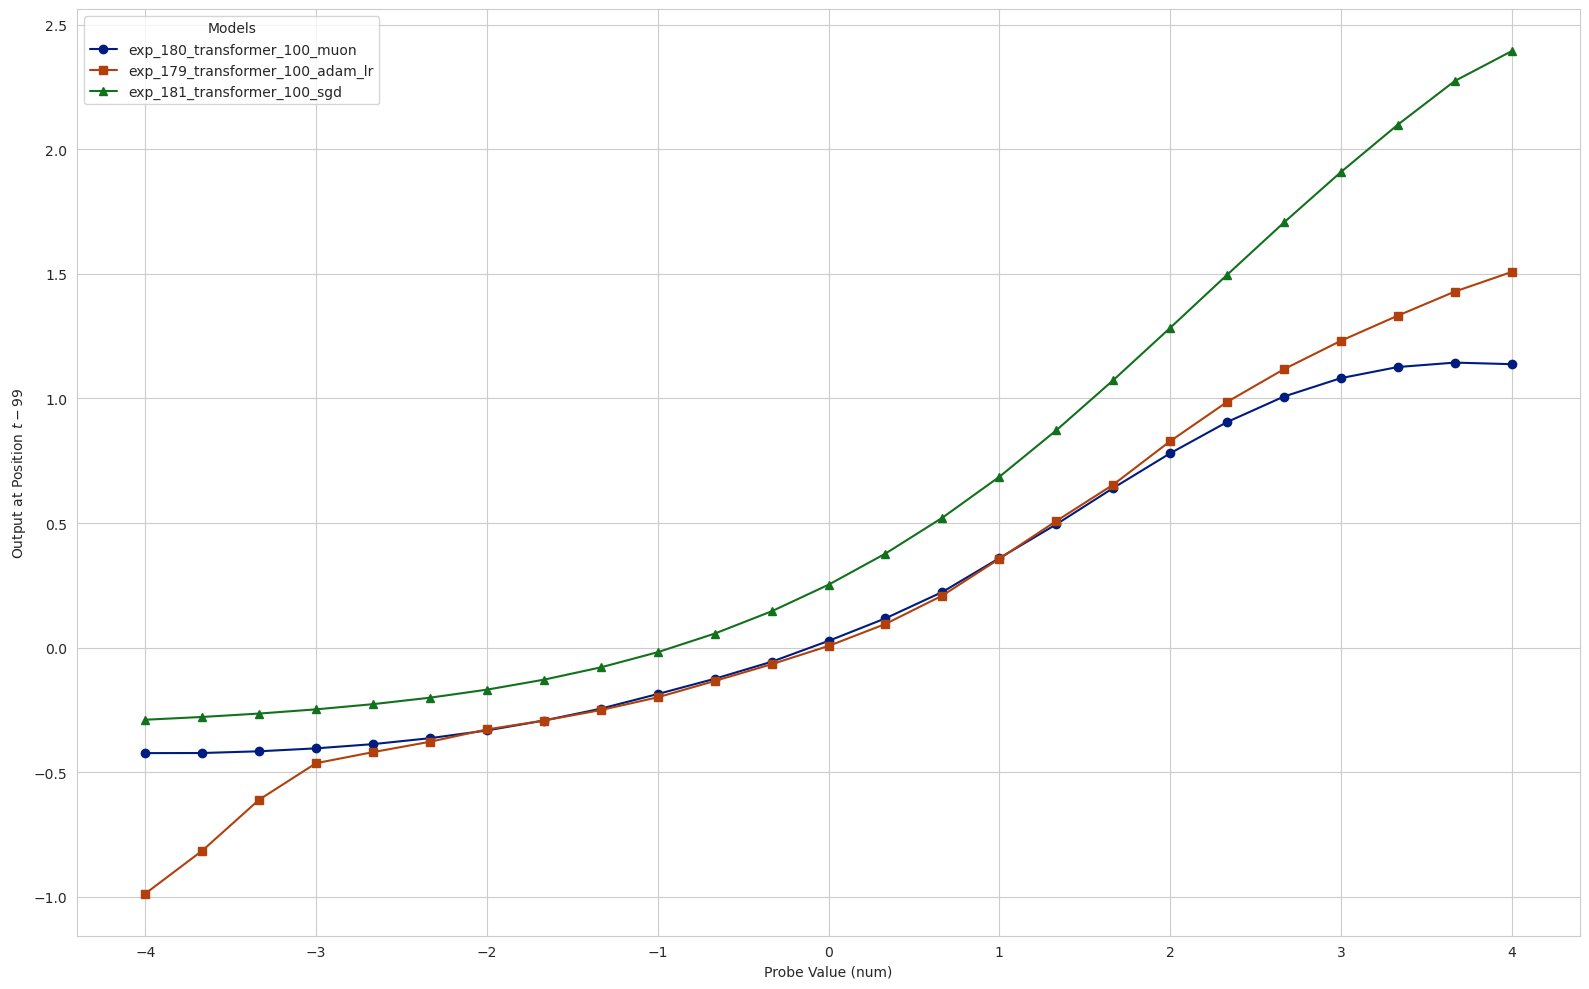

In [59]:
size = 100
ys = []
nums = np.linspace(-4, 4, 25)
sns.set_style('whitegrid')
sns.set_palette("dark")
plt.figure(figsize=(16, 10))  # Set a larger figure size

#sub = [models[1], models[3]]
#plot_names = [f"LSTM_{i}" for i in range(len(models))]

markers = ['o', 's', '^', 'D', 'v', 'p', 'X', '*']
print(mses)
obs = 99

#names_temp = [c.replace('ICML', '').replace('LR', '') for c in clean_names]

for i, model in enumerate(models):
    inner_ys = []
    for n in nums:         
        #y = probe_num(model, cfgs[i], size, pacf_values=pacf_values, num=n).ravel()[obs]
        y = probe_num(model, cfgs[0], size, num=n).ravel()[obs]
        inner_ys.append(y)

    ys.append(inner_ys)
    #plt.plot(nums, inner_ys, label=f"{clean_names[i]} - MSEs {mses[i]:.4f}", marker=markers[i % len(markers)])  # Allow matplotlib to auto-select marker and linestyle
    plt.plot(nums, inner_ys, label=f"{names[i]}", marker=markers[i % len(markers)])  # Allow matplotlib to auto-select marker and linestyle

plt.xlabel("Probe Value (num)")
plt.ylabel(rf"Output at Position $t-{obs}$")
#plt.title(f"Model Outputs for Different Probe Values at observation {obs}")
plt.legend(title="Models")  # Add a legend with a title
plt.grid(True)
plt.tight_layout()
#plt.show()



In [66]:
n = 3
plt.figure(figsize=(20,10))
y_first = probe_num(models[0], cfgs[0], size, num=n).ravel()

y_rank = np.argsort(y_first)[::-1]  # Sort in descending order
print("Ranking of y_first in descending order:", y_rank)

#sns.barplot(y_first)


Ranking of y_first in descending order: [99 98 37 38 97 36 39 40 41 96 42 35 43 91 33 90 34 32 95 44 48 47 45 52
 46 79 49 80 51 89 50 62 57 53 61 58 85 86 78 81 63 68 59 60 56 92 94 77
 31 76 67 28 54 71 84 82 21 69 66 20 55 64 70 72 87 29 65 83 75 22  9 27
 30 73 23 10  8  4  5 19  3  6  7 24  2  0  1 26 74 25 88 11 18 93 14 13
 17 12 15 16]


<Figure size 2000x1000 with 0 Axes>

In [44]:
models_to_plot = [models[i] for i in cool_indeces]

len(models_to_plot)
len(cool_indeces)
cool_names

['mlp_lr0.0050',
 'mlp_lr0.0010',
 'mlp_lr0.0100',
 'mlp_lr0.0750',
 'mlp_lr0.0250',
 'mlp_lr0.0075']

0it [00:00, ?it/s]

$L^2_1$ norm of the surface 3.8999231831387644
$L^2_1$ norm of the surface 3.327450478382588


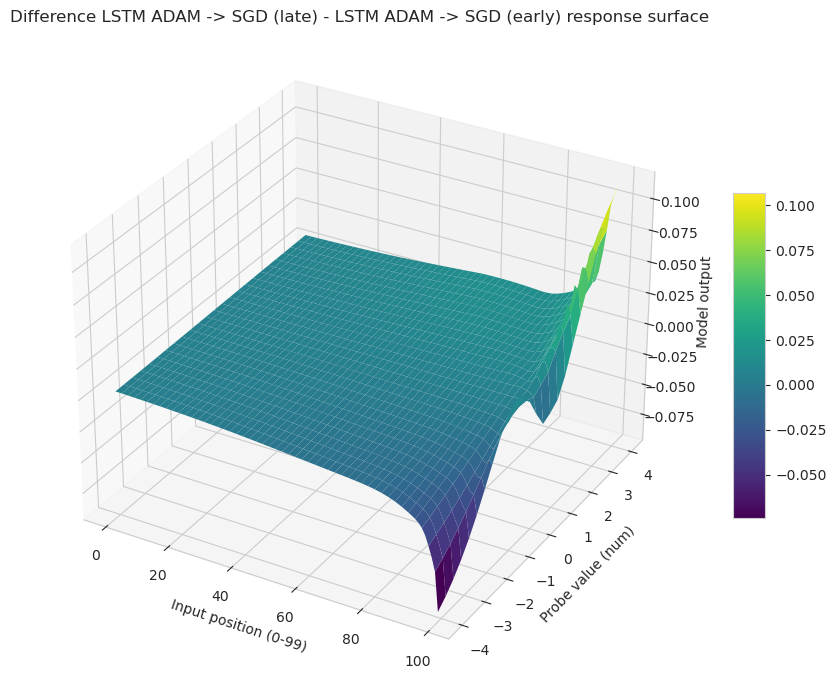

1it [00:05,  5.57s/it]

3.327450478382588
$L^2_1$ norm of the surface 3.8999231831387644
$L^2_1$ norm of the surface 3.114472714074349


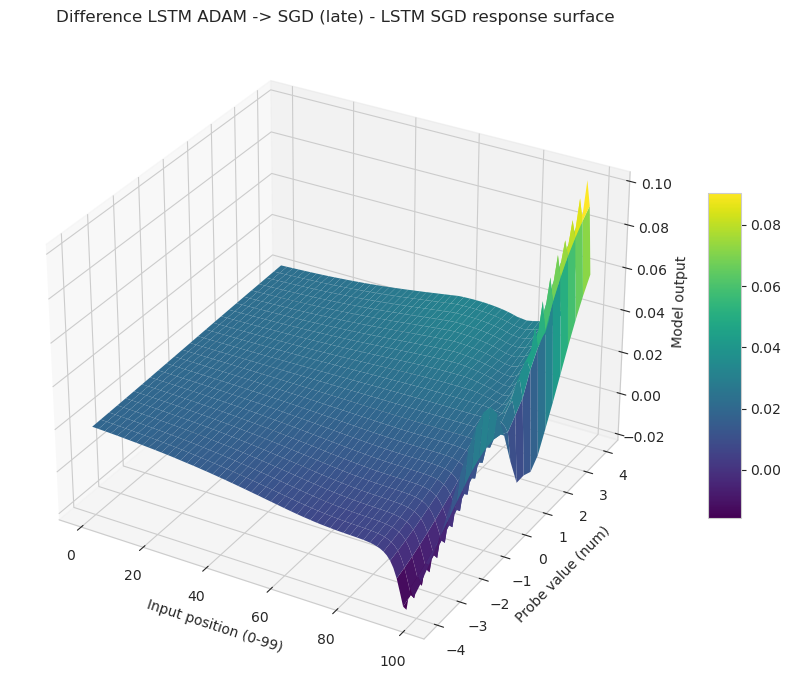

2it [00:11,  5.57s/it]

3.114472714074349


2it [00:13,  6.72s/it]


KeyboardInterrupt: 

In [60]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3d projection
import itertools

# Set a prettier palette
sns.set_palette("coolwarm")
sns.set_style("whitegrid")


def plot_3d(sub, cfgs, names, pacf, heatmap=True, diff=[0,0]):
    size = 100                      # input dimension
    nums = np.linspace(-4, 4, 25)   # values you’re probing
    all_arrays = []
    for model_n, (model, cfg) in enumerate(zip(sub, cfgs)):
        Z = np.zeros((len(nums), size))
        for i, n in enumerate(nums):
            # assuming probe_num returns shape (size,) or (size,1)
            y = probe_num(model, cfg, size, pacf_values=pacf, num=n).ravel()

            Z[i, :] = y

        # append for diff    
        all_arrays.append(Z)

        X, Y = np.meshgrid(np.arange(size), nums)  # X: position, Y: num

        #fig = plt.figure(figsize=(10, 7))
        #ax = fig.add_subplot(111, projection='3d')
        #surf = ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0, antialiased=True)
        #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        #ax.set_xlabel("Input position (0-99)")
        #ax.set_ylabel("Probe value (num)")
        #ax.set_zlabel(f"Model output")
        #ax.set_title(f"{names[model_n]} response surface")
        #plt.tight_layout()
        #plt.show()
  
        print(rf"$L^2_1$ norm of the surface {np.linalg.norm(Z.reshape(-1,1))}")

        if heatmap:

            fig = plt.figure(figsize=(10, 7))
            sns.heatmap(Z[::-1], cmap="viridis", cbar_kws={'label': 'Model output'}, 
                        xticklabels=True, yticklabels=True)
            plt.xlabel("Input position")
            plt.ylabel("Probe value (num)")
            ax.set_title(f"{names[model_n]} 2D response surface")
            #plt.tight_layout()
            #plt.show()
 
    if diff[0] != diff[1]:
        Z_diff = all_arrays[diff[0]] - all_arrays[diff[1]]
        X, Y = np.meshgrid(np.arange(size), nums)  # X: position, Y: num

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z_diff, cmap="viridis", linewidth=0, antialiased=True)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        ax.set_xlabel("Input position (0-99)")
        ax.set_ylabel("Probe value (num)")
        ax.set_zlabel(f"Model output")
        ax.set_title(f"Difference {names[diff[0]]} - {names[diff[1]]} response surface")
        plt.tight_layout()
        plt.show()

        print(np.linalg.norm(Z.reshape(-1,1)))

        if heatmap:

            fig = plt.figure(figsize=(10, 7))
            sns.heatmap(Z_diff, cmap="viridis", cbar_kws={'label': 'Model output'}, 
                        xticklabels=True, yticklabels=True)
            plt.xlabel("Input position")
            plt.xlabel("Input position")
            plt.title("Difference (position vs value)")
            ax.set_title(f"Difference {names[diff[0]]} - {names[diff[1]]} 2D response surface")
            plt.tight_layout()
            plt.show()

    return 

from tqdm import tqdm

#plot_3d(models[:3], cfgs[:3], names_temp[:3], pacf=None, heatmap=False, diff=[0, 1])
pairs = list(itertools.combinations(sub, 2))
pairs_names = list(itertools.combinations(sub_names, 2))
for p, n in tqdm(zip(pairs, pairs_names)):
    plot_3d(p, cfgs, n, pacf=None, heatmap=False, diff=[0, 1])

In [ ]:
def get_attention_maps(model, x, layer_idx=0):
    """
    Extracts attention weights for all heads from a specific layer.
    x shape: (1, T, D)
    """
    model.eval()
    with torch.no_grad():
        # 1. Reach the latent space (identical to your forward pass)
        if model.projection == 'linear':
            h = model.input_proj(x)
        elif model.projection == 'conv':
            h = x.permute(0, 2, 1).clone()
            h = model.input_proj(h)
            h = h.permute(0, 2, 1).clone()
        
        h = model.pos_encoder(h)

        # 2. Pass through layers BEFORE the one we want to visualize
        for i in range(layer_idx):
            h = model.transformer_encoder.layers[i](h)

        # 3. Extract weights from the specific layer's MultiheadAttention
        # We call self_attn directly to get (attn_output, attn_weights)
        # Setting average_attn_weights=False gives us (B, Heads, T, T)
        attn_layer = model.transformer_encoder.layers[layer_idx].self_attn
        _, weights = attn_layer(h, h, h, need_weights=True, average_attn_weights=False)
        
    return weights.cpu().numpy() # (1, nheads, T, T)

def probe_attention_surface(model, size=100):
    model.eval()
    # Detect the device the model is living on
    device = next(model.parameters()).device
    
    reconstructed_attn = np.zeros((size, size))

    for j in range(size):
        # Move x_probe to the correct device immediately
        x_probe = torch.zeros((1, size, 1), device=device)
        x_probe[0, j, 0] = 1.0  
        
        weights = get_attention_maps(model, x_probe, layer_idx=0)
        reconstructed_attn[:, j] = weights[0, 0, :, j]

    return reconstructed_attn

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_impulse_response_grid(model, d_model=128, n_lags=100, head_idx=0, layer_idx=0):
    """
    Probes the model with a '1.0' shock at different positions and 
    plots the resulting 100x100 attention matrices in a 5x5 grid.
    """
    model.eval()
    # Sample every 4th day to fit a 5x5 grid (25 plots)
    probe_positions = np.linspace(0, n_lags - 1, 25, dtype=int)
    
    fig, axes = plt.subplots(5, 5, figsize=(25, 20))
    axes = axes.flatten()

    for idx, pos in enumerate(probe_positions):
        # 1. Construct the Impulse Input
        # We use 0.0 as background, but mean-vol is more rigorous
        x = torch.zeros((1, n_lags, 1)).to(next(model.parameters()).device)
        x[0, pos, 0] = 3.0  # Input a 3-sigma 'shock'
        
        # 2. Extract Weights (Using your previous surgical function)
        with torch.no_grad():
            weights = get_attention_maps(model, x, layer_idx=layer_idx)
            # weights shape: (1, nheads, 100, 100)
            attn_matrix = weights[0, head_idx] # (100, 100)

        # 3. Plotting
        sns.heatmap(attn_matrix, ax=axes[idx], cmap='magma', cbar=False, 
                    xticklabels=False, yticklabels=False)
        
        axes[idx].set_title(f"Shock at Day {pos}")
        
        # Draw a small indicator of where the shock was on the plot axes
        axes[idx].axvline(x=pos, color='cyan', linestyle='--', alpha=0.5)
        axes[idx].axhline(y=pos, color='cyan', linestyle='--', alpha=0.5)

    plt.suptitle(f"Attention Layer {layer_idx} | Head {head_idx} | Delta Impulse Response", fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
probe_attention_surface(models[0])

AttributeError: 'CNN1D' object has no attribute 'projection'

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3d projection
import itertools
from tqdm import tqdm

# Set a prettier palette
sns.set_palette("coolwarm")
sns.set_style("whitegrid")


import math
import numpy as np
import matplotlib.pyplot as plt
import datetime

def plot_int(sub, cfgs, names, pos=[-1, -2], diff=[0, 0]):
    size = 100
    vals = np.linspace(-4, 4, 25)
    X, Y = np.meshgrid(vals, vals, indexing="ij")

    all_arrays = []

    n_models = len(sub)
    ncols = 3
    nrows = math.ceil(n_models / ncols)

    # One big figure for all individual surfaces
    fig = plt.figure(figsize=(5 * ncols, 4 * nrows))
    fig.suptitle(
    f"Interaction feature {pos[0]} and {pos[1]}",
    fontsize=20,
    y=1.02
    )


    for model_n, (model, cfg) in enumerate(zip(sub, cfgs)):
        Z = np.zeros((len(vals), len(vals)))

        for i, v in enumerate(vals):
            for j, u in enumerate(vals):
                z = probe_interaction(
                    model, cfg, size, pos=pos, nums=[v, u]
                ).ravel()
                Z[i, j] = z

        all_arrays.append(Z)

        ax = fig.add_subplot(nrows, ncols, model_n + 1, projection='3d')
        surf = ax.plot_surface(Y, X, Z, cmap="viridis", linewidth=0, antialiased=True)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

        ax.set_ylabel(f"Feature {pos[0]}")
        ax.set_xlabel(f"Feature {pos[1]}")
        ax.set_zlabel("Model output")
        ax.set_title(f"{names[model_n]} response surface")

        #print(rf"$L^2_1$ norm of the surface {np.linalg.norm(Z.reshape(-1, 1))}")

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    name = f'interactions_{pos[0]:03d}_{pos[1]:03d}_{timestamp}'
    plt.tight_layout()
    plt.savefig(f'./images/{name}.png')
    #plt.show()

    # ---- Difference surface (unchanged behavior) ----
    if diff[0] != diff[1]:
        Z_diff = all_arrays[diff[0]] - all_arrays[diff[1]]

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z_diff, cmap="viridis", linewidth=0, antialiased=True)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

        ax.set_xlabel(f"Feature {pos[0]}")
        ax.set_ylabel(f"Feature {pos[1]}")
        ax.set_zlabel("Model output")
        ax.set_title(f"Difference {names[diff[0]]} - {names[diff[1]]} response surface")
        plt.tight_layout()
        #plt.show()

        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        name = f'interactions_diff_{diff[0]:03d}_{diff[1]:03d}_{timestamp}'
        plt.savefig(f'./images/{name}.png')

        print(np.linalg.norm(Z_diff.reshape(-1, 1)))



pairs = list(itertools.combinations(features, 2))
for p in tqdm(pairs):
    continue

    plot_int(models, cfgs, clean_names, pos=p, diff=[0,0])

100%|██████████| 78/78 [00:00<00:00, 1982761.89it/s]


In [70]:
#plot_3d(models, cfgs, clean_names, pacf=None, heatmap=True, diff=[0,1])

In [71]:
def compute_empirical_cov(X):
    """
    X is a list/array of inputs X[i], each can be 1D or 2D;
    we flatten them to compute covariance.
    """
    X_flat = np.array([np.ravel(x) for x in X])  # (N, D)
    mu = X_flat.mean(axis=0)
    cov = np.cov(X_flat, rowvar=False)          # (D, D)
    return mu, cov

@torch.inference_mode()
def perturbate_input(model, cfg, X_test, y_test, limit=None, device="cuda", perturbation="gaussian"):
    """
    Sequential single-row inference over chronologically sorted X_test.
    For autoregressive=True, we start from X_test[0] and then roll forward
    using our own predictions.
    Returns (y_true, preds) with shape (N, output_dim).
    """
    preds = []
    limit = len(X_test) if limit is None else limit

    perturbation = perturbation.lower()

    allowed = ["gaussian", "uniform"]
    assert perturbation in allowed, f"Only {allowed} are allowed as perturbation."

    if perturbation == "gaussian":
        mu, sigma = compute_empirical_cov(X_test)
    
    for i in range(limit):
        x_in = X_test[i]
        if perturbation == "gaussian":
            p = np.random.multivariate_normal(mean=mu, cov=sigma)
            x_in = x_in + p*0.5

        # Debug: check shapes
        # print("x_in shape:", np.asarray(x_in).shape)

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)


    preds = np.vstack(preds)  # (N, output_dim)
    y_true = np.asarray(y_test[:limit])
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    return y_true, preds


#y_true_per, y_pred_per = perturbate_input(model_first, cfg_lstm, X_test_use, y_test_use)
#y_true_seq, y_pred_seq_first = infer_sequential(model_first, cfg_lstm, X_test_use, y_test_use)
#
## Print
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_first, title=f"{name} - fold {fold_num}")
#plot_forecast_overlay(X_test_use[0], y_true_per, y_pred_per, title=f"Gaussian perturbation  - fold {fold_num}")

In [33]:
len(models)

4

Summarizing background with K-Means...
Background shape: (250, 100)
Explain shape:   (100, 100)
Computing SHAP values (this may still take a bit)...


100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


SHAP values shape: (100, 100)


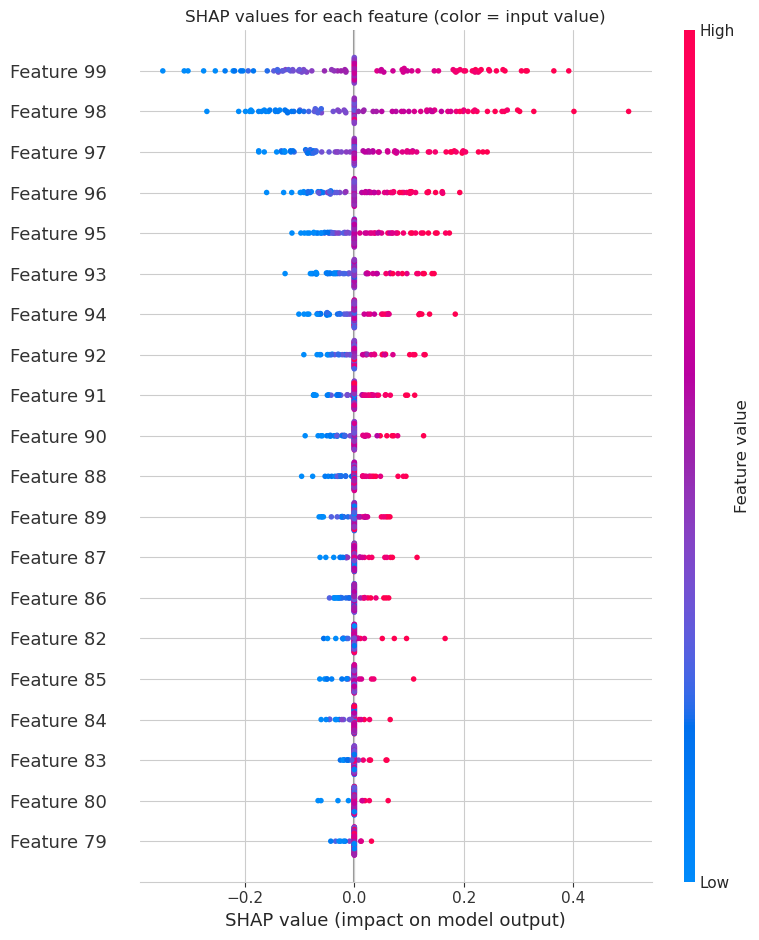

Summarizing background with K-Means...
Background shape: (250, 100)
Explain shape:   (100, 100)
Computing SHAP values (this may still take a bit)...


100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


SHAP values shape: (100, 100)


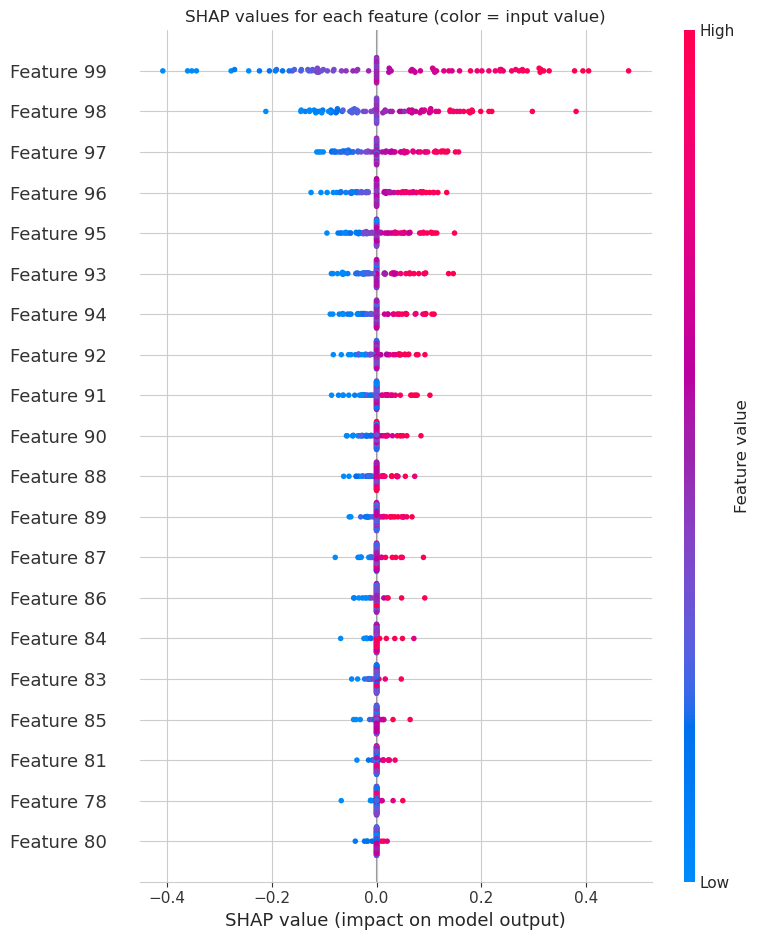

Summarizing background with K-Means...
Background shape: (250, 100)
Explain shape:   (100, 100)
Computing SHAP values (this may still take a bit)...


100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


SHAP values shape: (100, 100)


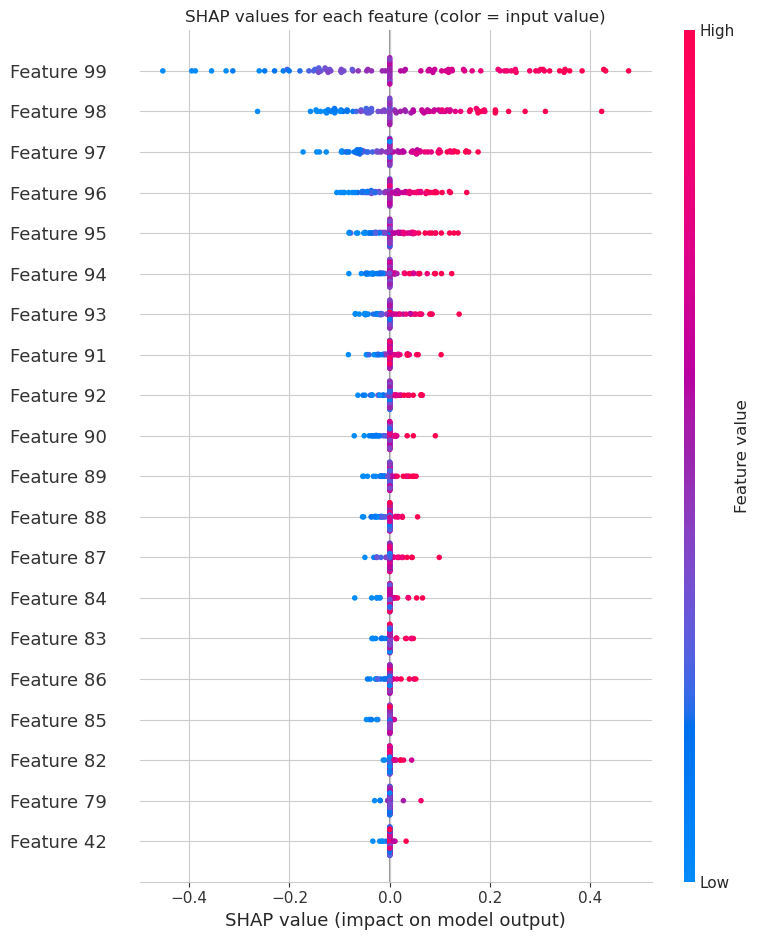

Summarizing background with K-Means...
Background shape: (250, 100)
Explain shape:   (100, 100)
Computing SHAP values (this may still take a bit)...


100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


SHAP values shape: (100, 100)


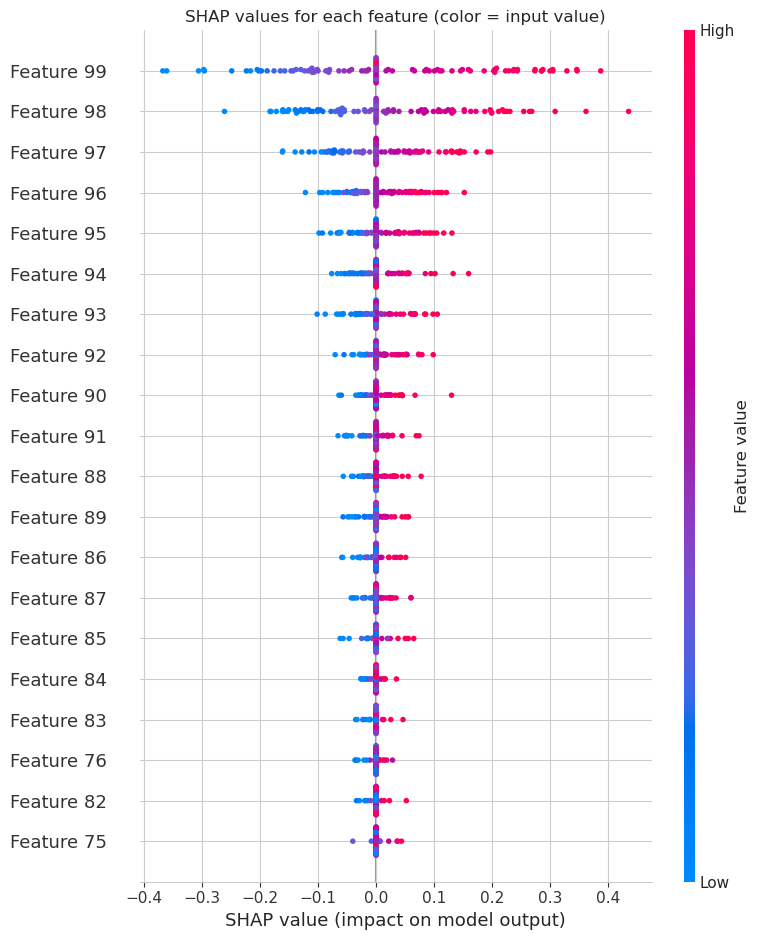

In [34]:
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt

model_shap_results = {}

# ------------------------------------------------------------------
# 1. Take your already-trained model and make a CPU copy for SHAP
# ------------------------------------------------------------------
# good only for recurrent
cfg
for model, cfg, name in zip(models, cfgs, names):
    MODEL = model                      # your trained model
    SHAP_DEVICE = torch.device("cuda")

    MODEL_SHAP = MODEL.to(SHAP_DEVICE).eval()   # copy weights to CPU for SHAP only

    if "lstm" in name.lower():

        # ------------------------------------------------------------------
        # 2. Prediction wrapper with batching (X: (N, 100))
        # ------------------------------------------------------------------
        def model_predict_wrapper(X):
            """
            Wrapper for SHAP to call our trained model on CPU, in batches.

            X: array-like, shape (N, 100)
            Returns: numpy array, shape (N,)
            """
            # Handle pandas DataFrame / list input
            X = np.asarray(X, dtype=np.float32)

            batch_size = 128   # keep this modest to control memory
            preds = []

            with torch.inference_mode():
                for start in range(0, len(X), batch_size):
                    xb = X[start:start + batch_size]
                    xb_torch = torch.from_numpy(xb).to(SHAP_DEVICE)

                    # Reshape exactly as you did during training
                    if cfg.model.name.lower() == "lstm":
                        # from (B, 100) -> (B, 100, 1)
                        xb_torch = xb_torch.unsqueeze(-1)
                    elif cfg.model.name.lower() == "simplecnn":
                        # from (B, 100) -> (B, 1, 100)
                        xb_torch = xb_torch.unsqueeze(1)

                    out = MODEL_SHAP(xb_torch).cpu().numpy().ravel()
                    preds.append(out)

            return np.concatenate(preds, axis=0)

        # ------------------------------------------------------------------
        # 3. Choose small background / explanation sets
        # ------------------------------------------------------------------
        # Make sure Xtr, Xte are numpy arrays
        Xtr_np = np.asarray(Xtr, dtype=np.float32)
        Xte_np = np.asarray(Xte, dtype=np.float32)

        n_background = 250    # smaller is safer for Kernel SHAP
        n_explain   = 100

        n_background_centroids = 15 
        print("Summarizing background with K-Means...")
        X_background_summary = shap.kmeans(Xtr_np, n_background_centroids)

        rng = np.random.default_rng(0)  # reproducible

        background_idx = rng.choice(len(Xtr_np),
                                    size=min(n_background, len(Xtr_np)),
                                    replace=False)
        X_background = Xtr_np[background_idx]

        explain_idx = rng.choice(len(Xte_np),
                                size=min(n_explain, len(Xte_np)),
                                replace=False)
        X_explain = Xte_np[explain_idx]

        print(f"Background shape: {X_background.shape}")
        print(f"Explain shape:   {X_explain.shape}")

        # ------------------------------------------------------------------
        # 4. Create KernelExplainer and compute SHAP values (with nsamples cap)
        # ------------------------------------------------------------------
        #explainer = shap.KernelExplainer(model_predict_wrapper, X_background)
        explainer = shap.KernelExplainer(model_predict_wrapper, X_background_summary)

        print("Computing SHAP values (this may still take a bit)...")
        shap_values = explainer.shap_values(
            X_explain,
            nsamples=250,   # IMPORTANT: cap number of coalitions to control cost
        )

        shap_values = np.array(shap_values)     # ensure ndarray (n_explain, n_features)
        model_shap_results[name] = shap_values
        print(f"SHAP values shape: {shap_values.shape}")

        # ------------------------------------------------------------------
        # 5. Visualizations
        # ------------------------------------------------------------------
        # Summary scatter plot
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values, X_explain, show=False)
        plt.title("SHAP values for each feature (color = input value)")
        plt.tight_layout()
        plt.show()




In [ ]:
5//2


2

In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt
import shap

def plot_shap_comparison(results, X_explain_data, max_display=15, ncols=4, feature_names=None):
    """
    results: dict {model_name: shap_values_array}
    X_explain_data: (N, D)
    """
    items = list(results.items())
    n_models = len(items)
    if n_models == 0:
        raise ValueError("results is empty.")

    # 1) Global max mean |SHAP| for shared x-axis
    global_max = 0.0
    for _, sv in items:
        sv = np.asarray(sv)
        mean_abs = np.mean(np.abs(sv), axis=0)
        global_max = max(global_max, float(np.max(mean_abs)))


    # 2) Grid
    nrows = math.ceil(n_models / ncols)
    ncols = min(n_models, ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 6 * nrows), sharey=False)

    # ALWAYS flatten to 1D list of Axes
    axes = np.atleast_1d(axes).ravel()

    # 3) Plot
    for ax, (name, sv) in zip(axes, items):
        plt.sca(ax)
        shap.summary_plot(
            sv,
            X_explain_data,
            plot_type="bar",
            show=False,
            feature_names=feature_names,
            max_display=max_display,
            plot_size=None,
        )
        ax.set_title(str(name), fontsize=12, fontweight="bold")
        ax.set_xlabel("mean(|SHAP value|)")

    # 4) Turn off unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

if len(model_shap_results) > 0: 
    # --- EXECUTE PLOT ---
    plot_shap_comparison(model_shap_results, X_explain)

NameError: name 'model_shap_results' is not defined

Background shape (numpy): (500, 100)
Explain shape (numpy):    (1000, 100)
Using standard shape: (B, 100)
Background shape (tensor): torch.Size([500, 100])
Explain shape (tensor):    torch.Size([1000, 100])
Computing SHAP values...
Raw SHAP shape: (1000, 100, 1)
Shape AFTER fix:  (1000, 100)
Plot-ready SHAP shape: (1000, 100)


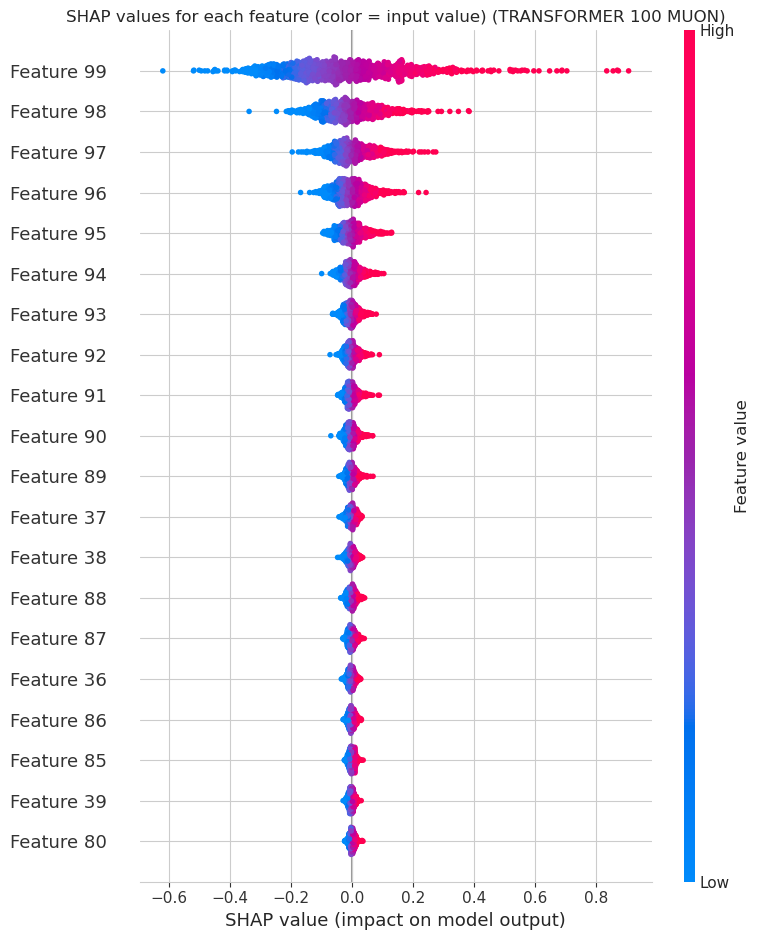

Background shape (numpy): (500, 100)
Explain shape (numpy):    (1000, 100)
Using standard shape: (B, 100)
Background shape (tensor): torch.Size([500, 100])
Explain shape (tensor):    torch.Size([1000, 100])
Computing SHAP values...
Raw SHAP shape: (1000, 100, 1)
Shape AFTER fix:  (1000, 100)
Plot-ready SHAP shape: (1000, 100)


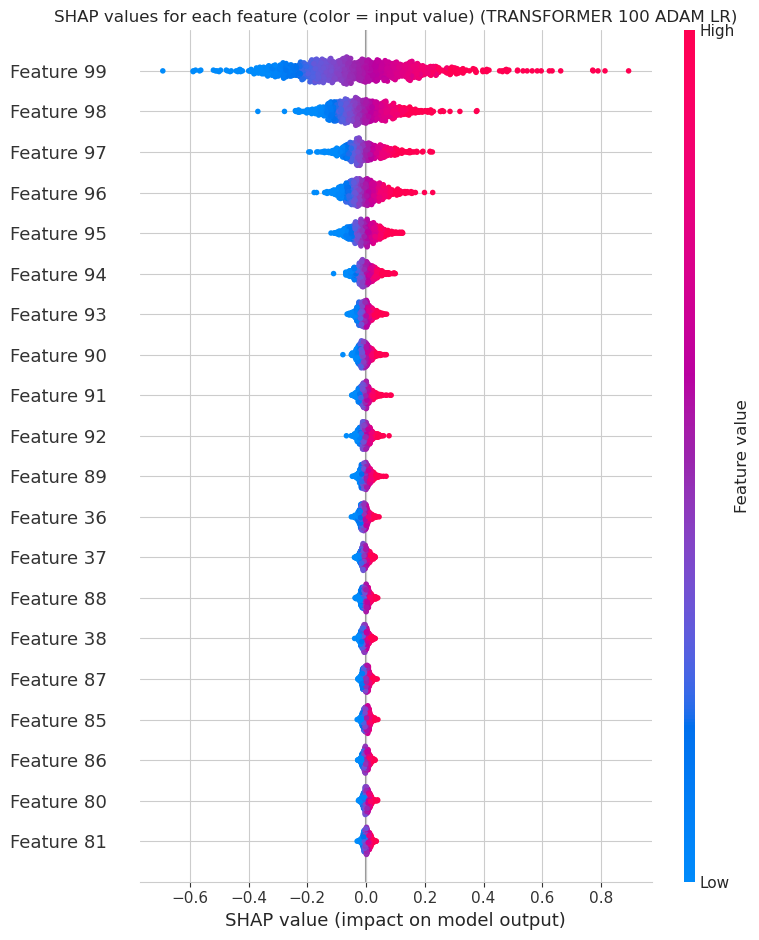

Background shape (numpy): (500, 100)
Explain shape (numpy):    (1000, 100)
Using standard shape: (B, 100)
Background shape (tensor): torch.Size([500, 100])
Explain shape (tensor):    torch.Size([1000, 100])
Computing SHAP values...
Raw SHAP shape: (1000, 100, 1)
Shape AFTER fix:  (1000, 100)
Plot-ready SHAP shape: (1000, 100)


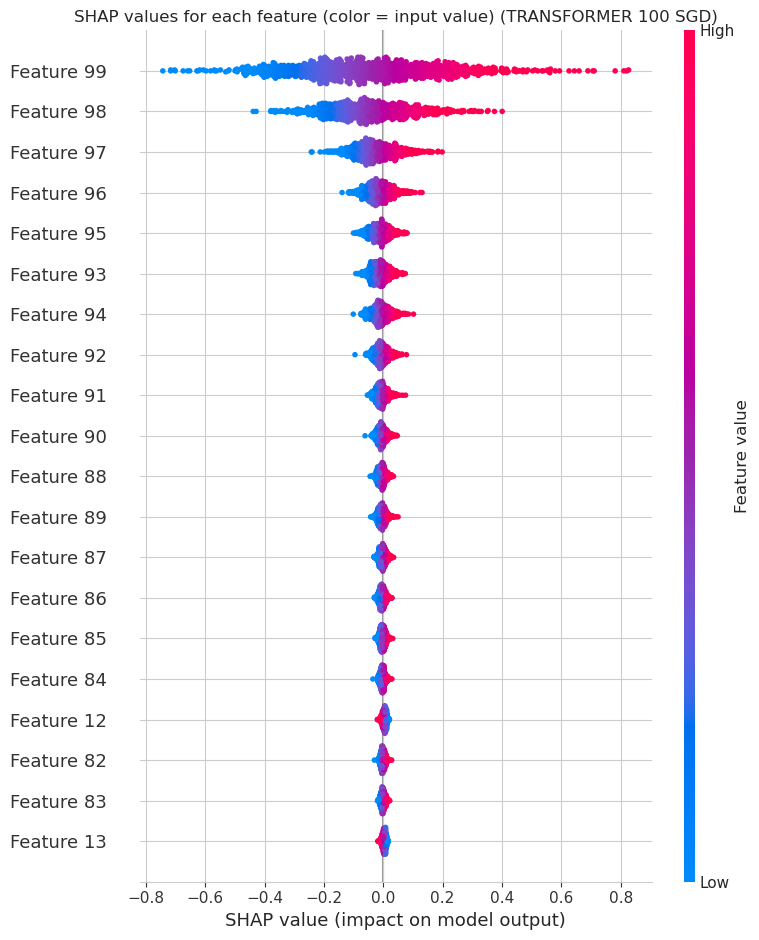

In [63]:
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt


model_shap_results = {}

# ------------------------------------------------------------------
# 1. Take your already-trained model and make a CPU copy for SHAP
# ------------------------------------------------------------------
# good only for recurrent
for model, cfg, name in zip(models, cfgs, clean_names):

    MODEL = model                      # your trained model
    SHAP_DEVICE = torch.device("cuda")

    MODEL_SHAP = MODEL.to(SHAP_DEVICE).eval() 

    # ------------------------------------------------------------------
    # 2. Choose Representative Background / Explanation Sets
    # ------------------------------------------------------------------
    # Make sure Xtr, Xte are numpy arrays
    Xtr_np = np.asarray(Xtr, dtype=np.float32)
    Xte_np = np.asarray(Xte, dtype=np.float32)

    n_background = 500   # Increased from 30 for better baseline
    n_explain = 1000     # Increased for more comprehensive explanation set

    rng = np.random.default_rng(0) # reproducible

    background_idx = rng.choice(len(Xtr_np),
                                size=min(n_background, len(Xtr_np)),
                                replace=False)
    X_background_np = Xtr_np[background_idx]

    explain_idx = rng.choice(len(Xte_np),
                            size=min(n_explain, len(Xte_np)),
                            replace=False)
    X_explain_np = Xte_np[explain_idx]

    print(f"Background shape (numpy): {X_background_np.shape}")
    print(f"Explain shape (numpy):    {X_explain_np.shape}")


    # ------------------------------------------------------------------
    # 3. Convert Data to Tensors and Apply Correct Reshaping
    # ------------------------------------------------------------------

    # Convert background data to torch tensor on GPU
    X_background_torch = torch.from_numpy(X_background_np).to(SHAP_DEVICE)

    # Convert explanation data to torch tensor on GPU
    X_explain_torch = torch.from_numpy(X_explain_np).to(SHAP_DEVICE)


    # Apply Reshaping based on model type (Crucial step for DeepExplainer)
    if cfg.model.name.lower() == "lstm":
        print('here')
        # from (B, 100) -> (B, 100, 1)
        X_background_torch = X_background_torch.unsqueeze(-1)
        X_explain_torch = X_explain_torch.unsqueeze(-1)
        print("Reshaping for LSTM: (B, 100) -> (B, 100, 1)")
    elif cfg.model.name.lower() == "simplecnn":
        # from (B, 100) -> (B, 1, 100)
        X_background_torch = X_background_torch.unsqueeze(1)
        X_explain_torch = X_explain_torch.unsqueeze(1)
        print("Reshaping for SimpleCNN: (B, 100) -> (B, 1, 100)")
    else:
        print("Using standard shape: (B, 100)")

    print(f"Background shape (tensor): {X_background_torch.shape}")
    print(f"Explain shape (tensor):    {X_explain_torch.shape}")


    # ------------------------------------------------------------------
    # 4. Create DeepExplainer and compute SHAP values
    # ------------------------------------------------------------------
    explainer = shap.DeepExplainer(MODEL_SHAP, X_background_torch)

    print("Computing SHAP values...")
    # Note: check_additivity=False is often needed for LSTMs/CNNs if you see errors
    shap_values_collection = explainer.shap_values(X_explain_torch, check_additivity=False)

    # --- ROBUST UNPACKING ---
    # 1. Check if it's a list (standard SHAP behavior) or an array (edge case)
    if isinstance(shap_values_collection, list):
        # If list, usually one array per model output. We take the first.
        shap_values = shap_values_collection[0]
    else:
        # If it's already an array/tensor, use it directly. 
        # DO NOT use [0] here, or you slice the batch!
        shap_values = shap_values_collection

    # Ensure it's numpy
    if hasattr(shap_values, 'cpu'):
        shap_values = shap_values.cpu().numpy()
    elif not isinstance(shap_values, np.ndarray):
        shap_values = np.array(shap_values)

    print(f"Raw SHAP shape: {shap_values.shape}") 
    # Expected: (1000, 1, 100)

    # --- SQUEEZE DIMENSIONS ---
    # 2. Fix the shape mismatch for plotting
    # The plot expects (N_samples, N_features).
    # Your CNN output is likely (N_samples, 1, N_features) or (N_samples, N_features, 1).
    try:
        shap_values = shap_values.reshape(X_explain_np.shape)
        model_shap_results[name] = shap_values
    except ValueError as e:
        print(f"Reshape failed! Total elements don't match.")
        print(f"SHAP elements: {shap_values.size}, Data elements: {X_explain_np.size}")
        raise e

    print(f"Shape AFTER fix:  {shap_values.shape}")

    print(f"Plot-ready SHAP shape: {shap_values.shape}")
    # Expected: (1000, 100)

    # ------------------------------------------------------------------
    # 5. Visualization
    # ------------------------------------------------------------------
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_explain_np, show=False)
    plt.title(f"SHAP values for each feature (color = input value) ({name})")
    plt.tight_layout()
    plt.show()


In [67]:
new_res = {}
for k,v in model_shap_results.items():
    if ' LR' in k:
        k = k.replace(' LR', '')

    new_res[k] = v


new_res

{'TRANSFORMER 100 MUON': array([[ 3.18222260e-03,  3.90172773e-03,  2.90096947e-03, ...,
         -2.58329734e-02, -4.70431037e-02, -2.26227373e-01],
        [ 9.65627562e-03,  4.36637318e-03,  3.29839392e-03, ...,
          2.05114600e-03,  5.05658574e-02,  2.71889195e-03],
        [ 3.91099509e-03,  2.12868489e-03,  2.98790331e-03, ...,
          3.84665988e-02,  1.82099659e-02, -2.49408439e-01],
        ...,
        [ 1.14741887e-03,  1.12433475e-03,  9.59218538e-04, ...,
         -5.20513877e-02, -9.42493379e-02, -3.48646075e-01],
        [ 2.60072848e-04,  1.75004406e-03, -1.63631560e-03, ...,
         -5.50036207e-02, -1.08295217e-01, -2.52153218e-01],
        [ 7.47593259e-03,  8.27590190e-03,  9.60839167e-03, ...,
          1.14744514e-01,  1.23190477e-01,  2.12355718e-01]],
       shape=(1000, 100)),
 'TRANSFORMER 100 ADAM': array([[ 0.00313239,  0.00416649,  0.00277479, ..., -0.03232293,
         -0.0607232 , -0.25101179],
        [ 0.0079893 ,  0.00403818,  0.00279287, ..., 

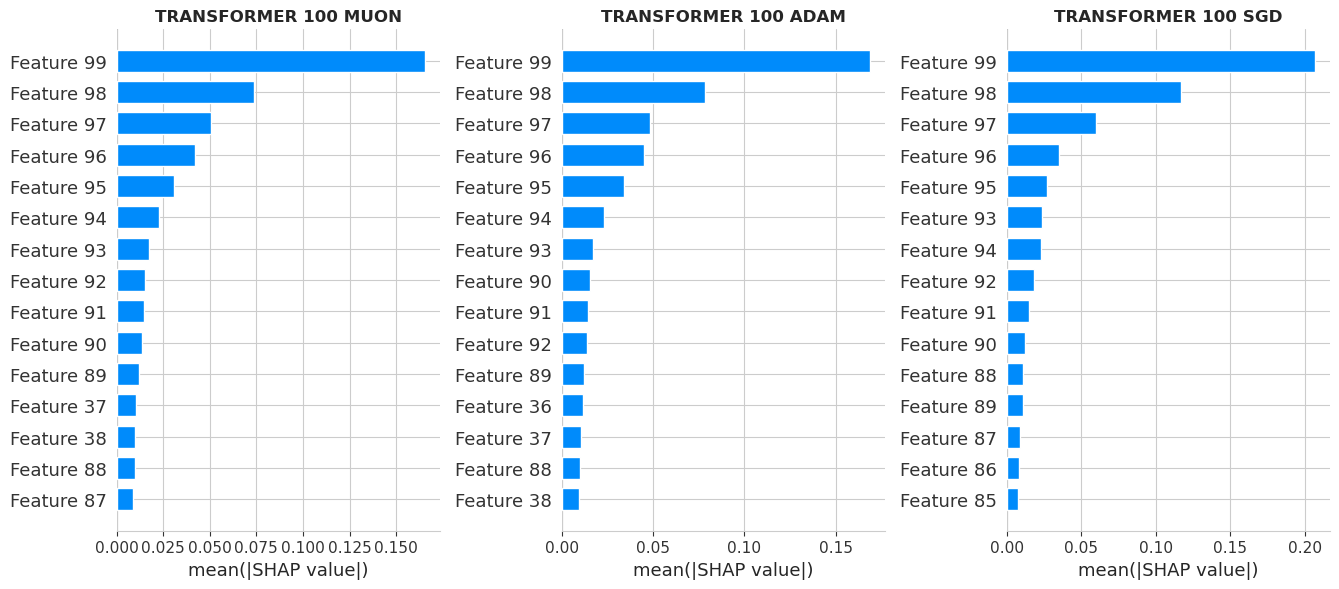

In [69]:
plot_shap_comparison(new_res, X_explain_torch.reshape(X_explain_torch.shape[0], -1))

{'CNN 100 ADAM LR': array([[ 2.63095484e-04,  5.31395432e-04,  3.52305389e-04, ...,
         -3.02834287e-02, -5.54169305e-02, -2.30645925e-01],
        [ 7.60248222e-04,  3.99272394e-04,  2.57607753e-04, ...,
         -1.01204228e-03,  5.72333783e-02,  1.62507035e-02],
        [ 4.16531024e-04,  8.52582307e-05,  3.43092368e-04, ...,
          4.52172086e-02,  2.39339471e-02, -2.27371931e-01],
        ...,
        [-1.12818030e-04, -2.86476570e-04, -3.23634769e-04, ...,
         -6.09484576e-02, -1.14556216e-01, -3.44056875e-01],
        [-2.39231114e-04,  1.14529445e-04, -1.90687936e-03, ...,
         -5.65426946e-02, -1.17094256e-01, -2.44460404e-01],
        [ 6.40546728e-04,  9.57375451e-04,  1.37017469e-03, ...,
          9.97182205e-02,  1.35336488e-01,  2.46682227e-01]],
       shape=(1000, 100)),
 'CNN 100 MUON ICML': array([[ 6.08117844e-04,  1.26822630e-03,  6.76366035e-04, ...,
         -3.41428295e-02, -6.73628971e-02, -2.35710487e-01],
        [ 2.00650655e-03,  1.06154499